This IPython Notebook illustrates the use of the **`openmc.mgxs.Library`** class. The `Library` class is designed to automate the calculation of multi-group cross sections for use cases with one or more domains, cross section types, and/or nuclides. In particular, this Notebook illustrates the following features:

* Calculation of multi-group cross sections for a **fuel assembly**
* Automated creation, manipulation and storage of `MGXS` with **`openmc.mgxs.Library`**
* **Validation** of multi-group cross sections with **[OpenMOC](https://mit-crpg.github.io/OpenMOC/)**
* Steady-state pin-by-pin **fission rates comparison** between OpenMC and [OpenMOC](https://mit-crpg.github.io/OpenMOC/)

**Note:** This Notebook was created using [OpenMOC](https://mit-crpg.github.io/OpenMOC/) to verify the multi-group cross-sections generated by OpenMC. You must install [OpenMOC](https://mit-crpg.github.io/OpenMOC/) on your system to run this Notebook in its entirety. In addition, this Notebook illustrates the use of [Pandas](http://pandas.pydata.org/) `DataFrames` to containerize multi-group cross section data.

## Generate Input Files

In [1]:
import math
import pickle

from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np

import openmc
import openmc.mgxs
from openmc.openmoc_compatible import get_openmoc_geometry
import openmoc
import openmoc.process
from openmoc.materialize import load_openmc_mgxs_lib

%matplotlib inline

/home/nelsonag/python/openmc/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


First we need to define materials that will be used in the problem. We'll create three materials for the fuel, water, and cladding of the fuel pins.

In [2]:
# 1.6 enriched fuel
fuel = openmc.Material(name='1.6% Fuel')
fuel.set_density('g/cm3', 10.31341)
fuel.add_nuclide('U235', 3.7503e-4)
fuel.add_nuclide('U238', 2.2625e-2)
fuel.add_nuclide('O16', 4.6007e-2)

# borated water
water = openmc.Material(name='Borated Water')
water.set_density('g/cm3', 0.740582)
water.add_nuclide('H1', 4.9457e-2)
water.add_nuclide('O16', 2.4732e-2)
water.add_nuclide('B10', 8.0042e-6)

# zircaloy
zircaloy = openmc.Material(name='Zircaloy')
zircaloy.set_density('g/cm3', 6.55)
zircaloy.add_nuclide('Zr90', 7.2758e-3)

With our three materials, we can now create a `Materials` object that can be exported to an actual XML file.

In [3]:
# Instantiate a Materials object
materials_file = openmc.Materials([fuel, water, zircaloy])

# Export to "materials.xml"
materials_file.export_to_xml()

Now let's move on to the geometry. This problem will be a square array of fuel pins and control rod guide tubes for which we can use OpenMC's lattice/universe feature. The basic universe will have three regions for the fuel, the clad, and the surrounding coolant. The first step is to create the bounding surfaces for fuel and clad, as well as the outer bounding surfaces of the problem.

In [4]:
# Create cylinders for the fuel and clad
fuel_outer_radius = openmc.ZCylinder(x0=0.0, y0=0.0, R=0.39218)
clad_outer_radius = openmc.ZCylinder(x0=0.0, y0=0.0, R=0.45720)

# Create boundary planes to surround the geometry
min_x = openmc.XPlane(x0=-10.71, boundary_type='reflective')
max_x = openmc.XPlane(x0=+10.71, boundary_type='reflective')
min_y = openmc.YPlane(y0=-10.71, boundary_type='reflective')
max_y = openmc.YPlane(y0=+10.71, boundary_type='reflective')
min_z = openmc.ZPlane(z0=-10., boundary_type='reflective')
max_z = openmc.ZPlane(z0=+10., boundary_type='reflective')

With the surfaces defined, we can now construct a fuel pin cell from cells that are defined by intersections of half-spaces created by the surfaces.

In [5]:
# Create a Universe to encapsulate a fuel pin
fuel_pin_universe = openmc.Universe(name='1.6% Fuel Pin')

# Create fuel Cell
fuel_cell = openmc.Cell(name='1.6% Fuel')
fuel_cell.fill = fuel
fuel_cell.region = -fuel_outer_radius
fuel_pin_universe.add_cell(fuel_cell)

# Create a clad Cell
clad_cell = openmc.Cell(name='1.6% Clad')
clad_cell.fill = zircaloy
clad_cell.region = +fuel_outer_radius & -clad_outer_radius
fuel_pin_universe.add_cell(clad_cell)

# Create a moderator Cell
moderator_cell = openmc.Cell(name='1.6% Moderator')
moderator_cell.fill = water
moderator_cell.region = +clad_outer_radius
fuel_pin_universe.add_cell(moderator_cell)

Likewise, we can construct a control rod guide tube with the same surfaces.

In [6]:
# Create a Universe to encapsulate a control rod guide tube
guide_tube_universe = openmc.Universe(name='Guide Tube')

# Create guide tube Cell
guide_tube_cell = openmc.Cell(name='Guide Tube Water')
guide_tube_cell.fill = water
guide_tube_cell.region = -fuel_outer_radius
guide_tube_universe.add_cell(guide_tube_cell)

# Create a clad Cell
clad_cell = openmc.Cell(name='Guide Clad')
clad_cell.fill = zircaloy
clad_cell.region = +fuel_outer_radius & -clad_outer_radius
guide_tube_universe.add_cell(clad_cell)

# Create a moderator Cell
moderator_cell = openmc.Cell(name='Guide Tube Moderator')
moderator_cell.fill = water
moderator_cell.region = +clad_outer_radius
guide_tube_universe.add_cell(moderator_cell)

Using the pin cell universe, we can construct a 17x17 rectangular lattice with a 1.26 cm pitch.

In [7]:
# Create fuel assembly Lattice
assembly = openmc.RectLattice(name='1.6% Fuel Assembly')
assembly.pitch = (1.26, 1.26)
assembly.lower_left = [-1.26 * 17. / 2.0] * 2

Next, we create a NumPy array of fuel pin and guide tube universes for the lattice.

In [8]:
# Create array indices for guide tube locations in lattice
template_x = np.array([5, 8, 11, 3, 13, 2, 5, 8, 11, 14, 2, 5, 8,
                       11, 14, 2, 5, 8, 11, 14, 3, 13, 5, 8, 11])
template_y = np.array([2, 2, 2, 3, 3, 5, 5, 5, 5, 5, 8, 8, 8, 8,
                       8, 11, 11, 11, 11, 11, 13, 13, 14, 14, 14])

# Initialize an empty 17x17 array of the lattice universes
universes = np.empty((17, 17), dtype=openmc.Universe)

# Fill the array with the fuel pin and guide tube universes
universes[:,:] = fuel_pin_universe
universes[template_x, template_y] = guide_tube_universe

# Store the array of universes in the lattice
assembly.universes = universes

OpenMC requires that there is a "root" universe. Let us create a root cell that is filled by the assembly and then assign it to the root universe.

In [9]:
# Create root Cell
root_cell = openmc.Cell(name='root cell')
root_cell.fill = assembly

# Add boundary planes
root_cell.region = +min_x & -max_x & +min_y & -max_y & +min_z & -max_z

# Create root Universe
root_universe = openmc.Universe(universe_id=0, name='root universe')
root_universe.add_cell(root_cell)

We now must create a geometry that is assigned a root universe and export it to XML.

In [10]:
# Create Geometry and set root Universe
geometry = openmc.Geometry(root_universe)

In [11]:
# Export to "geometry.xml"
geometry.export_to_xml()

With the geometry and materials finished, we now just need to define simulation parameters. In this case, we will use 10 inactive batches and 40 active batches each with 2500 particles.

In [12]:
# OpenMC simulation parameters
batches = 50
inactive = 10
particles = 10000

# Instantiate a Settings object
settings_file = openmc.Settings()
settings_file.batches = batches
settings_file.inactive = inactive
settings_file.particles = particles
settings_file.output = {'tallies': False}

# Create an initial uniform spatial source distribution over fissionable zones
bounds = [-10.71, -10.71, -10, 10.71, 10.71, 10.]
uniform_dist = openmc.stats.Box(bounds[:3], bounds[3:], only_fissionable=True)
settings_file.source = openmc.Source(space=uniform_dist)

# Export to "settings.xml"
settings_file.export_to_xml()

Let us also create a `Plots` file that we can use to verify that our fuel assembly geometry was created successfully.

In [13]:
# Instantiate a Plot
plot = openmc.Plot(plot_id=1)
plot.filename = 'materials-xy'
plot.origin = [0, 0, 0]
plot.pixels = [250, 250]
plot.width = [-10.71*2, -10.71*2]
plot.color_by = 'material'

# Instantiate a Plots object, add Plot, and export to "plots.xml"
plot_file = openmc.Plots([plot])
plot_file.export_to_xml()

With the plots.xml file, we can now generate and view the plot. OpenMC outputs plots in .ppm format, which can be converted into a compressed format like .png with the convert utility.

In [14]:
# Run openmc in plotting mode
openmc.plot_geometry(output=False)

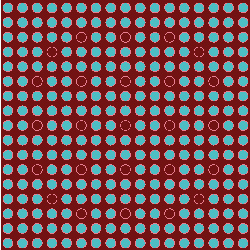

In [15]:
# Convert OpenMC's funky ppm to png
!convert materials-xy.ppm materials-xy.png

# Display the materials plot inline
Image(filename='materials-xy.png')

As we can see from the plot, we have a nice array of fuel and guide tube pin cells with fuel, cladding, and water!

## Create an MGXS Library

Now we are ready to generate multi-group cross sections! First, let's define a 2-group structure using the built-in `EnergyGroups` class.

In [16]:
# Instantiate a 2-group EnergyGroups object
groups = openmc.mgxs.EnergyGroups()
groups.group_edges = np.array([0., 0.625, 20.0e6])

Next, we will instantiate an `openmc.mgxs.Library` for the energy groups with the fuel assembly geometry.

In [17]:
# Initialize a 2-group MGXS Library for OpenMOC
mgxs_lib = openmc.mgxs.Library(geometry)
mgxs_lib.energy_groups = groups

Now, we must specify to the `Library` which types of cross sections to compute. In particular, the following are the multi-group cross section `MGXS` subclasses that are mapped to string codes accepted by the `Library` class:

* `TotalXS` (`"total"`)
* `TransportXS` (`"transport"` or `"nu-transport` with `nu` set to `True`)
* `AbsorptionXS` (`"absorption"`)
* `CaptureXS` (`"capture"`)
* `FissionXS` (`"fission"` or `"nu-fission"` with `nu` set to `True`)
* `KappaFissionXS` (`"kappa-fission"`)
* `ScatterXS` (`"scatter"` or `"nu-scatter"` with `nu` set to `True`)
* `ScatterMatrixXS` (`"scatter matrix"` or `"nu-scatter matrix"` with `nu` set to `True`)
* `Chi` (`"chi"`)
* `ChiPrompt` (`"chi prompt"`)
* `InverseVelocity` (`"inverse-velocity"`)
* `PromptNuFissionXS` (`"prompt-nu-fission"`)
* `DelayedNuFissionXS` (`"delayed-nu-fission"`)
* `ChiDelayed` (`"chi-delayed"`)
* `Beta` (`"beta"`)

In this case, let's create the multi-group cross sections needed to run an OpenMOC simulation to verify the accuracy of our cross sections. In particular, we will define `"nu-transport"`, `"nu-fission"`, `'"fission"`, `"nu-scatter matrix"` and `"chi"` cross sections for our `Library`.

**Note**: A variety of different approximate transport-corrected total multi-group cross sections (and corresponding scattering matrices) can be found in the literature. At the present time, the `openmc.mgxs` module only supports the `"P0"` transport correction. This correction can be turned on and off through the boolean `Library.correction` property which may take values of `"P0"` (default) or `None`.

In [18]:
# Specify multi-group cross section types to compute
mgxs_lib.mgxs_types = ['nu-transport', 'nu-fission', 'fission', 'nu-scatter matrix', 'chi']

Now we must specify the type of domain over which we would like the `Library` to compute multi-group cross sections. The domain type corresponds to the type of tally filter to be used in the tallies created to compute multi-group cross sections. At the present time, the `Library` supports `"material"`, `"cell"`, `"universe"`, and `"mesh"` domain types. We will use a `"cell"` domain type here to compute cross sections in each of the cells in the fuel assembly geometry.

**Note:** By default, the `Library` class will instantiate `MGXS` objects for each and every domain (material, cell or universe) in the geometry of interest. However, one may specify a subset of these domains to the `Library.domains` property. In our case, we wish to compute multi-group cross sections in each and every cell since they will be needed in our downstream OpenMOC calculation on the identical combinatorial geometry mesh.

In [19]:
# Specify a "cell" domain type for the cross section tally filters
mgxs_lib.domain_type = 'cell'

# Specify the cell domains over which to compute multi-group cross sections
mgxs_lib.domains = geometry.get_all_material_cells().values()

We can easily instruct the `Library` to compute multi-group cross sections on a nuclide-by-nuclide basis with the boolean `Library.by_nuclide` property. By default, `by_nuclide` is set to `False`, but we will set it to `True` here.

In [20]:
# Compute cross sections on a nuclide-by-nuclide basis
mgxs_lib.by_nuclide = True

Lastly, we use the `Library` to construct the tallies needed to compute all of the requested multi-group cross sections in each domain and nuclide.

In [21]:
# Construct all tallies needed for the multi-group cross section library
mgxs_lib.build_library()

The tallies can now be export to a "tallies.xml" input file for OpenMC. 

**NOTE**: At this point the `Library` has constructed nearly 100 distinct `Tally` objects. The overhead to tally in OpenMC scales as $O(N)$ for $N$ tallies, which can become a bottleneck for large tally datasets. To compensate for this, the Python API's `Tally`, `Filter` and `Tallies` classes allow for the smart *merging* of tallies when possible. The `Library` class supports this runtime optimization with the use of the optional `merge` paramter (`False` by default) for the `Library.add_to_tallies_file(...)` method, as shown below.

In [22]:
# Create a "tallies.xml" file for the MGXS Library
tallies_file = openmc.Tallies()
mgxs_lib.add_to_tallies_file(tallies_file, merge=True)

In addition, we instantiate a fission rate mesh tally to compare with OpenMOC.

In [23]:
# Instantiate a tally Mesh
mesh = openmc.RegularMesh(mesh_id=1)
mesh.dimension = [17, 17]
mesh.lower_left = [-10.71, -10.71]
mesh.upper_right = [+10.71, +10.71]

# Instantiate tally Filter
mesh_filter = openmc.MeshFilter(mesh)

# Instantiate the Tally
tally = openmc.Tally(name='mesh tally')
tally.filters = [mesh_filter]
tally.scores = ['fission', 'nu-fission']

# Add tally to collection
tallies_file.append(tally)

In [24]:
# Export all tallies to a "tallies.xml" file
tallies_file.export_to_xml()

/home/nelsonag/git/openmc/openmc/mixin.py:71: IDWarning: Another Filter instance already exists with id=126.
  warn(msg, IDWarning)
/home/nelsonag/git/openmc/openmc/mixin.py:71: IDWarning: Another Filter instance already exists with id=21.
  warn(msg, IDWarning)
/home/nelsonag/git/openmc/openmc/mixin.py:71: IDWarning: Another Filter instance already exists with id=2.
  warn(msg, IDWarning)
/home/nelsonag/git/openmc/openmc/mixin.py:71: IDWarning: Another Filter instance already exists with id=3.
  warn(msg, IDWarning)
/home/nelsonag/git/openmc/openmc/mixin.py:71: IDWarning: Another Filter instance already exists with id=4.
  warn(msg, IDWarning)
/home/nelsonag/git/openmc/openmc/mixin.py:71: IDWarning: Another Filter instance already exists with id=96.
  warn(msg, IDWarning)
/home/nelsonag/git/openmc/openmc/mixin.py:71: IDWarning: Another Filter instance already exists with id=15.
  warn(msg, IDWarning)
/home/nelsonag/git/openmc/openmc/mixin.py:71: IDWarning: Another Filter instance alre

In [25]:
# Run OpenMC
openmc.run()


                               %%%%%%%%%%%%%%%
                          %%%%%%%%%%%%%%%%%%%%%%%%
                       %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                     %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                  %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                   %%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                ###############      %%%%%%%%%%%%%%%%%%%%%%%%
               ##################     %%%%%%%%%%%%%%%%%%%%%%%
               ###################     %%%%%%%%%%%%%%%%%%%%%%%
               ####################     %%%%%%%%%%%%%%%%%%%%%%
               #####################     %%%%%%%%%%%%%%%%%%%%%
               ######################     %%%%%%%%%%%%%%%%%%%%
               #######################     %%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%

## Tally Data Processing

Our simulation ran successfully and created statepoint and summary output files. We begin our analysis by instantiating a `StatePoint` object. 

In [26]:
# Load the last statepoint file
sp = openmc.StatePoint('statepoint.50.h5')

The statepoint is now ready to be analyzed by the `Library`. We simply have to load the tallies from the statepoint into the `Library` and our `MGXS` objects will compute the cross sections for us under-the-hood.

In [27]:
# Initialize MGXS Library with OpenMC statepoint data
mgxs_lib.load_from_statepoint(sp)

Voila! Our multi-group cross sections are now ready to rock 'n roll!

## Extracting and Storing MGXS Data

The `Library` supports a rich API to automate a variety of tasks, including multi-group cross section data retrieval and storage. We will highlight a few of these features here. First, the `Library.get_mgxs(...)` method allows one to extract an `MGXS` object from the `Library` for a particular domain and cross section type. The following cell illustrates how one may extract the `NuFissionXS` object for the fuel cell.

**Note:** The `MGXS.get_mgxs(...)` method will accept either the domain *or* the integer domain ID of interest.

In [28]:
# Retrieve the NuFissionXS object for the fuel cell from the library
fuel_mgxs = mgxs_lib.get_mgxs(fuel_cell, 'nu-fission')

The `NuFissionXS` object supports all of the methods described previously in the `openmc.mgxs` tutorials, such as [Pandas](http://pandas.pydata.org/) `DataFrames`:
Note that since so few histories were simulated, we should expect a few division-by-error errors as some tallies have not yet scored any results.

In [29]:
df = fuel_mgxs.get_pandas_dataframe()
df

,cell,group in,nuclide,mean,std. dev.
3,1,1,U235,8.093482e-03,1.597406e-05
4,1,1,U238,7.347745e-03,2.082526e-05
5,1,1,O16,0.000000e+00,0.000000e+00
0,1,2,U235,3.615911e-01,1.206052e-03
1,1,2,U238,6.743056e-07,2.229534e-09
2,1,2,O16,0.000000e+00,0.000000e+00


Similarly, we can use the `MGXS.print_xs(...)` method to view a string representation of the multi-group cross section data.

In [30]:
fuel_mgxs.print_xs()

Multi-Group XS
	Reaction Type  =	nu-fission
	Domain Type    =	cell
	Domain ID      =	1
	Nuclide        =	U235
	Cross Sections [cm^-1]:
            Group 1 [0.625      - 20000000.0eV]:	8.09e-03 +/- 1.97e-01%
            Group 2 [0.0        - 0.625     eV]:	3.62e-01 +/- 3.34e-01%

	Nuclide        =	U238
	Cross Sections [cm^-1]:
            Group 1 [0.625      - 20000000.0eV]:	7.35e-03 +/- 2.83e-01%
            Group 2 [0.0        - 0.625     eV]:	6.74e-07 +/- 3.31e-01%

	Nuclide        =	O16
	Cross Sections [cm^-1]:
            Group 1 [0.625      - 20000000.0eV]:	0.00e+00 +/- 0.00e+00%
            Group 2 [0.0        - 0.625     eV]:	0.00e+00 +/- 0.00e+00%





/home/nelsonag/git/openmc/openmc/tallies.py:1269: RuntimeWarning: invalid value encountered in true_divide
  data = self.std_dev[indices] / self.mean[indices]


One can export the entire `Library` to HDF5 with the `Library.build_hdf5_store(...)` method as follows:

In [31]:
# Store the cross section data in an "mgxs/mgxs.h5" HDF5 binary file
mgxs_lib.build_hdf5_store(filename='mgxs.h5', directory='mgxs')

The HDF5 store will contain the numerical multi-group cross section data indexed by domain, nuclide and cross section type. Some data workflows may be optimized by storing and retrieving binary representations of the `MGXS` objects in the `Library`. This feature is supported through the `Library.dump_to_file(...)` and `Library.load_from_file(...)` routines which use Python's [`pickle`](https://docs.python.org/2/library/pickle.html) module. This is illustrated as follows.

In [32]:
# Store a Library and its MGXS objects in a pickled binary file "mgxs/mgxs.pkl"
mgxs_lib.dump_to_file(filename='mgxs', directory='mgxs')

In [33]:
# Instantiate a new MGXS Library from the pickled binary file "mgxs/mgxs.pkl"
mgxs_lib = openmc.mgxs.Library.load_from_file(filename='mgxs', directory='mgxs')

The `Library` class may be used to leverage the energy condensation features supported by the `MGXS` class. In particular, one can use the `Library.get_condensed_library(...)` with a coarse group structure which is a subset of the original "fine" group structure as shown below.

In [34]:
# Create a 1-group structure
coarse_groups = openmc.mgxs.EnergyGroups(group_edges=[0., 20.0e6])

# Create a new MGXS Library on the coarse 1-group structure
coarse_mgxs_lib = mgxs_lib.get_condensed_library(coarse_groups)

In [35]:
# Retrieve the NuFissionXS object for the fuel cell from the 1-group library
coarse_fuel_mgxs = coarse_mgxs_lib.get_mgxs(fuel_cell, 'nu-fission')

# Show the Pandas DataFrame for the 1-group MGXS
coarse_fuel_mgxs.get_pandas_dataframe()

,cell,group in,nuclide,mean,std. dev.
0,1,1,U235,0.074672,0.000179
1,1,1,U238,0.005964,0.000017
2,1,1,O16,0.000000,0.000000


## Verification with OpenMOC

Of course it is always a good idea to verify that one's cross sections are accurate. We can easily do so here with the deterministic transport code [OpenMOC](https://mit-crpg.github.io/OpenMOC/). We first construct an equivalent OpenMOC geometry.

In [36]:
# Create an OpenMOC Geometry from the OpenMC Geometry
openmoc_geometry = get_openmoc_geometry(mgxs_lib.geometry)

Now, we can inject the multi-group cross sections into the equivalent fuel assembly OpenMOC geometry. The `openmoc.materialize` module supports the loading of `Library` objects from OpenMC as illustrated below.

In [37]:
# Load the library into the OpenMOC geometry
materials = load_openmc_mgxs_lib(mgxs_lib, openmoc_geometry)

We are now ready to run OpenMOC to verify our cross-sections from OpenMC.

In [38]:
# Generate tracks for OpenMOC
track_generator = openmoc.TrackGenerator(openmoc_geometry, num_azim=32, azim_spacing=0.1)
track_generator.generateTracks()

# Run OpenMOC
solver = openmoc.CPUSolver(track_generator)
solver.computeEigenvalue()

[  NORMAL ]  Importing ray tracing data from file...
[  NORMAL ]  Computing the eigenvalue...
[  NORMAL ]  Iteration 0:	k_eff = 0.823436	res = 0.000E+00
[  NORMAL ]  Iteration 1:	k_eff = 0.780042	res = 1.941E-01
[  NORMAL ]  Iteration 2:	k_eff = 0.739063	res = 6.559E-02
[  NORMAL ]  Iteration 3:	k_eff = 0.710328	res = 5.301E-02
[  NORMAL ]  Iteration 4:	k_eff = 0.689038	res = 3.942E-02
[  NORMAL ]  Iteration 5:	k_eff = 0.674339	res = 3.021E-02
[  NORMAL ]  Iteration 6:	k_eff = 0.665075	res = 2.149E-02
[  NORMAL ]  Iteration 7:	k_eff = 0.660373	res = 1.387E-02
[  NORMAL ]  Iteration 8:	k_eff = 0.659460	res = 7.242E-03
[  NORMAL ]  Iteration 9:	k_eff = 0.661679	res = 1.995E-03
[  NORMAL ]  Iteration 10:	k_eff = 0.666463	res = 3.649E-03
[  NORMAL ]  Iteration 11:	k_eff = 0.673324	res = 7.367E-03
[  NORMAL ]  Iteration 12:	k_eff = 0.681842	res = 1.039E-02
[  NORMAL ]  Iteration 13:	k_eff = 0.691660	res = 1.273E-02
[  NORMAL ]  Iteration 14:	k_eff = 0.702469	res = 1.447E-02
[  NORMAL ]  Ite

We report the eigenvalues computed by OpenMC and OpenMOC here together to summarize our results.

In [39]:
# Print report of keff and bias with OpenMC
openmoc_keff = solver.getKeff()
openmc_keff = sp.k_combined.nominal_value
bias = (openmoc_keff - openmc_keff) * 1e5

print('openmc keff = {0:1.6f}'.format(openmc_keff))
print('openmoc keff = {0:1.6f}'.format(openmoc_keff))
print('bias [pcm]: {0:1.1f}'.format(bias))

openmc keff = 1.023293
openmoc keff = 1.024582
bias [pcm]: 128.8


There is a non-trivial bias between the eigenvalues computed by OpenMC and OpenMOC. One can show that these biases do not converge to <100 pcm with more particle histories. For heterogeneous geometries, additional measures must be taken to address the following three sources of bias:

* Appropriate transport-corrected cross sections
* Spatial discretization of OpenMOC's mesh
* Constant-in-angle multi-group cross sections

## Flux and Pin Power Visualizations

We will conclude this tutorial by illustrating how to visualize the fission rates computed by OpenMOC and OpenMC. First, we extract volume-integrated fission rates from OpenMC's mesh fission rate tally for each pin cell in the fuel assembly.

In [40]:
# Get the OpenMC fission rate mesh tally data
mesh_tally = sp.get_tally(name='mesh tally')
openmc_fission_rates = mesh_tally.get_values(scores=['nu-fission'])

# Reshape array to 2D for plotting
openmc_fission_rates.shape = (17,17)

# Normalize to the average pin power
openmc_fission_rates /= np.mean(openmc_fission_rates[openmc_fission_rates > 0.])

Next, we extract OpenMOC's volume-averaged fission rates into a 2D 17x17 NumPy array.

In [41]:
# Create OpenMOC Mesh on which to tally fission rates
openmoc_mesh = openmoc.process.Mesh()
openmoc_mesh.dimension = np.array(mesh.dimension)
openmoc_mesh.lower_left = np.array(mesh.lower_left)
openmoc_mesh.upper_right = np.array(mesh.upper_right)
openmoc_mesh.width = openmoc_mesh.upper_right - openmoc_mesh.lower_left
openmoc_mesh.width /= openmoc_mesh.dimension

# Tally OpenMOC fission rates on the Mesh
openmoc_fission_rates = openmoc_mesh.tally_fission_rates(solver)
openmoc_fission_rates = np.squeeze(openmoc_fission_rates)
openmoc_fission_rates = np.fliplr(openmoc_fission_rates)

# Normalize to the average pin fission rate
openmoc_fission_rates /= np.mean(openmoc_fission_rates[openmoc_fission_rates > 0.])

Now we can easily use Matplotlib to visualize the fission rates from OpenMC and OpenMOC side-by-side.

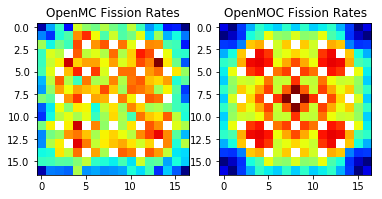

In [42]:
# Ignore zero fission rates in guide tubes with Matplotlib color scheme
openmc_fission_rates[openmc_fission_rates == 0] = np.nan
openmoc_fission_rates[openmoc_fission_rates == 0] = np.nan

# Plot OpenMC's fission rates in the left subplot
fig = plt.subplot(121)
plt.imshow(openmc_fission_rates, interpolation='none', cmap='jet')
plt.title('OpenMC Fission Rates')

# Plot OpenMOC's fission rates in the right subplot
fig2 = plt.subplot(122)
plt.imshow(openmoc_fission_rates, interpolation='none', cmap='jet')
plt.title('OpenMOC Fission Rates')